In [ ]:
# Run this
! git clone https://github.com/modraa-pixels/Snow-Covered-Roads-Dataset.git

Cloning into 'Snow-Covered-Roads-Dataset'...
remote: Enumerating objects: 42398, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 42398 (delta 7), reused 12 (delta 2), pack-reused 42371 (from 1)
Receiving objects: 100% (42398/42398), 2.46 GiB | 35.63 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (42401/42401), done.


In [ ]:
# Run this to set the paths
# Set Dataset Paths
train_dir = "/content/Snow-Covered-Roads-Dataset/dataset/train"
test_dir = "/content/Snow-Covered-Roads-Dataset/dataset/test"

In [ ]:
# This block isnt necessary currently, this will be for building the model

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 33661 files belonging to 4 classes.
Found 8733 files belonging to 4 classes.


In [ ]:
classes = train_ds.class_names
print(classes)
num_classes = len(classes)
print(num_classes)

['clear', 'light', 'medium', 'plowed']
4


In [ ]:
# Run this to verify github was cloned correctly
# Verify the structure
!ls Snow-Covered-Roads-Dataset/dataset

test  train


Class names: ['clear', 'light', 'medium', 'plowed']


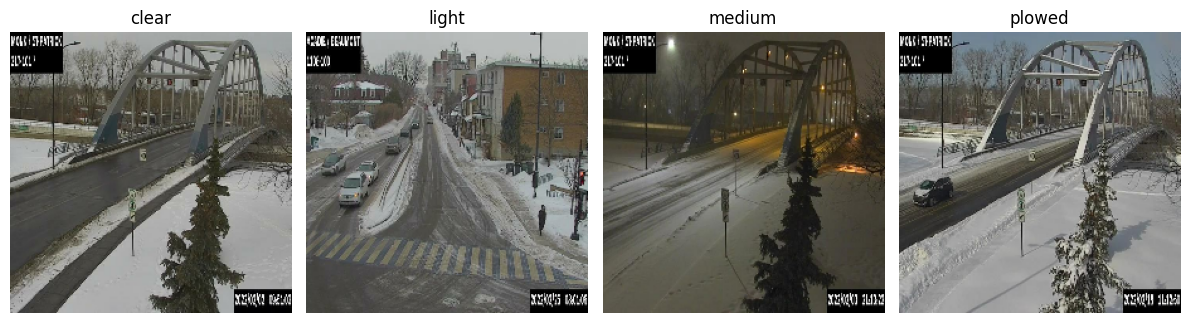

In [ ]:
# Not necessary
# Run this if you want to test the images are loading/printing correctly
# Print the first 5 images for testing
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)

# Dictionary to store first image of each class
first_images = {}

# Loop through batches until we have one of each class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in first_images:
            first_images[class_name] = img.numpy().astype("uint8")
        if len(first_images) == len(class_names):
            break
    if len(first_images) == len(class_names):
        break

# Plot the first image from each class
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(first_images[class_name])
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# We both run this
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os

# Make a folder in Google Drive to save everything
save_dir = "/content/drive/MyDrive/snow_scrape_project"
os.makedirs(save_dir, exist_ok=True)

# Load the full metadata
full_metadata_path = "/content/parsed_image_metadata.csv"  # If it exists already
df_full = pd.read_csv(full_metadata_path)

# Split into 2 parts
dfs_split = np.array_split(df_full, 2)

# Save split files
for i, split_df in enumerate(dfs_split):
    split_path = os.path.join(save_dir, f"parsed_image_metadata_part{i+1}.csv")
    split_df.to_csv(split_path, index=False)
    print(f"Saved {split_path}")

print("Metadata split into 2 parts and saved to Google Drive.")


In [ ]:
# First half of data

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import requests
from datetime import datetime
from tqdm import tqdm
import time
import os

# Working file for Person 1
working_file = "/content/drive/MyDrive/snow_scrape_project/parsed_image_metadata_part1.csv"
partial_save_path = "/content/drive/MyDrive/snow_scrape_project/partial_weather_part1.csv"

# Load metadata
df = pd.read_csv(working_file)

# Load existing progress if available
weather_data_map = {}

try:
    partial_weather_df = pd.read_csv(partial_save_path, index_col=0)
    completed_filenames = set(partial_weather_df.index)
    print(f"Found {len(completed_filenames)} entries already completed.")
    weather_data_map = partial_weather_df.to_dict(orient='index')
except FileNotFoundError:
    print("No previous weather data found. Starting fresh.")
    completed_filenames = set()

last_save_time = time.time()

# Scraping loop
for idx, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['filename']
    if filename in completed_filenames:
        continue

    datetime_str = row['datetime']
    lat = row['latitude']
    lon = row['longitude']

    try:
        dt = datetime.fromisoformat(datetime_str)
        date = dt.strftime("%Y-%m-%d")
        hour_str = dt.strftime("%H:00")

        url = (
            f"https://archive-api.open-meteo.com/v1/era5?"
            f"latitude={lat}&longitude={lon}"
            f"&start_date={date}&end_date={date}"
            f"&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,windspeed_10m"
            f"&timezone=America%2FToronto"
        )

        response = requests.get(url)
        time.sleep(1)

        if response.status_code == 200:
            data = response.json()
            times = data["hourly"]["time"]
            target_time = f"{date}T{hour_str}"

            if target_time in times:
                index = times.index(target_time)
                weather_data_map[filename] = {
                    "Air Temp (°C)": data["hourly"]["temperature_2m"][index],
                    "Relative Humidity (%)": data["hourly"]["relative_humidity_2m"][index],
                    "Dew Point (°C)": data["hourly"]["dew_point_2m"][index],
                    "Pressure (kPa)": data["hourly"]["surface_pressure"][index] / 1000,
                    "Wind Speed (km/h)": data["hourly"]["windspeed_10m"][index],
                }
                completed_filenames.add(filename)
            else:
                print(f"Time {hour_str} not found for {filename}")
        else:
            print(f"API call failed for {filename}: {response.status_code}")

        # Save every 100 entries or 5 minutes
        if idx % 100 == 0 or (time.time() - last_save_time) > 300:
            pd.DataFrame.from_dict(weather_data_map, orient='index').to_csv(partial_save_path, index_label='filename')
            print(f"Auto-saved partial results at {len(weather_data_map)} entries")
            last_save_time = time.time()

    except Exception as e:
        print(f"Error for {filename}: {e}")

# Final save
pd.DataFrame.from_dict(weather_data_map, orient='index').to_csv(partial_save_path, index_label='filename')
print(f"Finished! Total entries collected: {len(weather_data_map)}")


In [ ]:
# Second half of data

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import requests
from datetime import datetime
from tqdm import tqdm
import time
import os

# Working file for Person 2
working_file = "/content/drive/MyDrive/snow_scrape_project/parsed_image_metadata_part2.csv"
partial_save_path = "/content/drive/MyDrive/snow_scrape_project/partial_weather_part2.csv"

# Load metadata
df = pd.read_csv(working_file)

# Load existing progress if available
weather_data_map = {}

try:
    partial_weather_df = pd.read_csv(partial_save_path, index_col=0)
    completed_filenames = set(partial_weather_df.index)
    print(f"Found {len(completed_filenames)} entries already completed.")
    weather_data_map = partial_weather_df.to_dict(orient='index')
except FileNotFoundError:
    print("No previous weather data found. Starting fresh.")
    completed_filenames = set()

last_save_time = time.time()

# Scraping loop
for idx, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['filename']
    if filename in completed_filenames:
        continue

    datetime_str = row['datetime']
    lat = row['latitude']
    lon = row['longitude']

    try:
        dt = datetime.fromisoformat(datetime_str)
        date = dt.strftime("%Y-%m-%d")
        hour_str = dt.strftime("%H:00")

        url = (
            f"https://archive-api.open-meteo.com/v1/era5?"
            f"latitude={lat}&longitude={lon}"
            f"&start_date={date}&end_date={date}"
            f"&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,windspeed_10m"
            f"&timezone=America%2FToronto"
        )

        response = requests.get(url)
        time.sleep(1)

        if response.status_code == 200:
            data = response.json()
            times = data["hourly"]["time"]
            target_time = f"{date}T{hour_str}"

            if target_time in times:
                index = times.index(target_time)
                weather_data_map[filename] = {
                    "Air Temp (°C)": data["hourly"]["temperature_2m"][index],
                    "Relative Humidity (%)": data["hourly"]["relative_humidity_2m"][index],
                    "Dew Point (°C)": data["hourly"]["dew_point_2m"][index],
                    "Pressure (kPa)": data["hourly"]["surface_pressure"][index] / 1000,
                    "Wind Speed (km/h)": data["hourly"]["windspeed_10m"][index],
                }
                completed_filenames.add(filename)
            else:
                print(f"Time {hour_str} not found for {filename}")
        else:
            print(f"API call failed for {filename}: {response.status_code}")

        # Save every 100 entries or 5 minutes
        if idx % 100 == 0 or (time.time() - last_save_time) > 300:
            pd.DataFrame.from_dict(weather_data_map, orient='index').to_csv(partial_save_path, index_label='filename')
            print(f"Auto-saved partial results at {len(weather_data_map)} entries")
            last_save_time = time.time()

    except Exception as e:
        print(f"Error for {filename}: {e}")

# Final save
pd.DataFrame.from_dict(weather_data_map, orient='index').to_csv(partial_save_path, index_label='filename')
print(f"Finished! Total entries collected: {len(weather_data_map)}")
